# Connecting to G-Drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd gdrive/My Drive/SUBJECTS /PROJECTS/ML-DISTRACTED-DRIVER  
!ls

[Errno 2] No such file or directory: 'gdrive/My Drive/SUBJECTS /PROJECTS/ML-DISTRACTED-DRIVER'
/content/gdrive/My Drive/SUBJECTS /PROJECTS/ML-DISTRACTED-DRIVER
 cache			        images_all_224.np
 cache-2		        labels_all_224.np
 data			       'ML Report.gdoc'
 data2			        ML-Report-text.gdoc
'DISTRACTED DRIVER-CNN.ipynb'   models
'DISTRACTED DRIVER.ipynb'      'PCA Variance Graph'
 EndSem			        resized_data_64_64_3
'Feature Extraction Images'    'Submission-Before midsem'
'Final - DD.ipynb'	        test
'FINAL IMAGES'		        train


# Import statements 

In [4]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
import joblib
import pickle
import pandas as pd 
import copy
import skimage.transform
from torch import topk
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from sklearn.metrics import classification_report

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
!nvidia-smi

Fri Dec 18 22:16:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import data 

In [8]:
train_imgs = np.load('data/train_imgs.npy')
train_y = np.load('data/train_y.npy')
val_imgs = np.load('data/val_imgs.npy')
val_y = np.load('data/val_y.npy')

X = np.load('data/X.npy')
y = np.load('data/y.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')

In [39]:
# confusion matrix code 
import itertools
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
def confusion_matrix2(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(os.path.join(path, title + '.png'))
            else:
                plt.savefig(os.path.join(path, filename + '.png'))
        plt.show()

# Preprocess data and Data Loaders 

In [9]:
# train_imgs2 = []
# val_imgs2 = []
# # change channels last to channels first format
# for img in train_imgs:
#   img = np.moveaxis(img, 2, 0)
#   train_imgs2.append(img)
  
# for img in val_imgs:
#   img = np.moveaxis(img, 2, 0)
#   val_imgs2.append(img)

# train_imgs2 = np.array(train_imgs2)
# val_imgs2 = np.array(val_imgs2)

In [10]:
# data transform to size 224*224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# data transform to size 64*64
data_transforms2 = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        x = Image.fromarray(x).convert('RGB')
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

    def get_transformed(self):
      self.data2 = []
      for x in self.data:
        x = Image.fromarray(x)
        self.data2.append(self.transform(x))
      return torch.from_numpy(np.array(self.data2)).float()


# dataset 
train_dataset = MyDataset(train_imgs, train_y, data_transforms['train'])
val_dataset = MyDataset(val_imgs,val_y,data_transforms['val'])
test_dataset = MyDataset(X_test,y_test,data_transforms['test'])

train_dataset2 = MyDataset(train_imgs, train_y, data_transforms2['train'])
val_dataset2 = MyDataset(val_imgs,val_y,data_transforms2['val'])
test_dataset2 = MyDataset(X_test,y_test,data_transforms2['test'])

In [12]:
torch.manual_seed(42)
# loaders for images of size 224*224 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# loaders for images of size 64*64
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)
valid_loader2 = DataLoader(val_dataset2, batch_size=32, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)

In [13]:
# next(iter(train_loader))[0].shape

# Training 

## Traning function for CNN 

In [15]:
# def train_model(train_loader, test_loader, model, criterion, optimizer, epochs, print_every=50):
#     start_time = datetime.now()
#     steps = 0
#     running_loss = 0
#     for epoch in range(epochs):
#         for inputs, labels in train_loader:
#             steps += 1
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             y_pred = model(inputs)
#             loss = criterion(y_pred, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#             if steps % print_every == 0:
#                 test_loss = 0
#                 accuracy = 0
#                 model.eval()
#                 with torch.no_grad():
#                     for inputs, labels in test_loader:
#                         inputs, labels = inputs.to(device), labels.to(device)
#                         y_val = model(inputs)
#                         test_loss += criterion(y_val, labels)
#                         ps = torch.exp(y_val)
#                         top_p, top_class = ps.topk(1, dim=1)
#                         equals = top_class == labels.view(*top_class.shape)
#                         accuracy += torch.mean(equals.type(torch.FloatTensor))
#                 print(
#                     f'Epoch {epoch + 1} / {epochs}.. '
#                     f'Train loss: {running_loss/print_every:.3f}.. '
#                     f'Valid loss: {test_loss/len(test_loader):.3f}.. '
#                     f'Valid accuracy: {accuracy/len(test_loader):.3f}'
#                 )
#                 running_loss = 0
#                 model.train()
#     time_delta = datetime.now() - start_time
#     print()
#     print(f'TRAINING FINISHED! Training time: {str(timedelta(seconds=time_delta.seconds))}')
#     return model

In [14]:
def train_model(train_loader, test_loader, model, criterion, optimizer, epochs, save_path):
    start_time = datetime.now()
    valid_loss_min = np.Inf 
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        
        ##########
        #TRAINING 
        ##########
        model.train()
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # steps += 1
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)

            loss.backward()
            optimizer.step()

            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # running_loss += loss.item()


        ##########
        #VALIDATION 
        ##########
        model.eval()
        for batch_idx, (inputs, labels)  in enumerate(test_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            y_val = model(inputs)
            loss =  criterion(y_val, labels)

            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

       # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        
        if valid_loss < valid_loss_min:
            print('Saving model..')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
    
    # return trained model
    return model, train_losses, val_losses

### CNN model1 

In [80]:
# USES IMAGES OF SIZE 64*64 WITH 3 CHANNELS 

In [15]:
class CNN_model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=6*6*32, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.out = nn.Linear(in_features=256, out_features=10)
        
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print(x.size())
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.size())
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.size())
        x = x.view(-1, 6*6*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        # x = F.sigmoid(x, p=0.2)
        return self.out(x)

torch.manual_seed(42)

model_1 = CNN_model_1()
model_1.to(device)
model_1

CNN_model_1(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [83]:
# CNN_model_1_64 , train_losses_cnn_1, val_losses_cnn_1 = train_model(
#     train_loader=train_loader2,
#     test_loader=valid_loader2,
#     model=model_1,
#     criterion=criterion,
#     optimizer=optimizer,
#     epochs=20, save_path = 'models/Cnn_model_1_img_64.pt' 
# )



Epoch: 0 	Training Loss: 1.211541 	Validation Loss: 0.531509
Saving model..
Epoch: 1 	Training Loss: 0.304917 	Validation Loss: 0.275605
Saving model..
Epoch: 2 	Training Loss: 0.171016 	Validation Loss: 0.232334
Saving model..
Epoch: 3 	Training Loss: 0.120453 	Validation Loss: 0.152310
Saving model..
Epoch: 4 	Training Loss: 0.095120 	Validation Loss: 0.138657
Saving model..
Epoch: 5 	Training Loss: 0.076684 	Validation Loss: 0.140409
Epoch: 6 	Training Loss: 0.068318 	Validation Loss: 0.086805
Saving model..
Epoch: 7 	Training Loss: 0.062402 	Validation Loss: 0.132921
Epoch: 8 	Training Loss: 0.054069 	Validation Loss: 0.085941
Saving model..
Epoch: 9 	Training Loss: 0.054494 	Validation Loss: 0.214523
Epoch: 10 	Training Loss: 0.044736 	Validation Loss: 0.083493
Saving model..
Epoch: 11 	Training Loss: 0.039462 	Validation Loss: 0.120720
Epoch: 12 	Training Loss: 0.046385 	Validation Loss: 0.093216
Epoch: 13 	Training Loss: 0.035244 	Validation Loss: 0.179191
Epoch: 14 	Training Lo

In [17]:
CNN_model_1_64 = CNN_model_1()
CNN_model_1_64.to(device)
CNN_model_1_64.load_state_dict(torch.load('models/Cnn_model_1_img_64.pt'))

<All keys matched successfully>

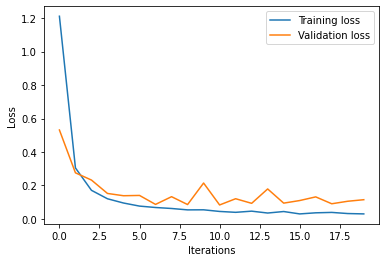

In [92]:

# np.save('cache/ train_losses_cnn_1.npy', train_losses_cnn_1)
# np.save('cache/ val_losses_cnn_1.npy', val_losses_cnn_1)

train_losses_cnn_1 = np.load('cache/ train_losses_cnn_1.npy', allow_pickle=True)
val_losses_cnn_1 = np.load('cache/ val_losses_cnn_1.npy',allow_pickle=True)

plt.plot(train_losses_cnn_1, label='Training loss')
plt.plot(val_losses_cnn_1, label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
_ = plt.ylim()
# plt.title('Training Validation Loss with CNN from scratch')
# plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
plt.show()


### CNN model2 

In [18]:
class CNN_model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=26*26*32, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.out = nn.Linear(in_features=256, out_features=10)
        
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print(x.size())
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.size())
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.size())
        x = x.view(-1, 26*26*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        return self.out(x)

torch.manual_seed(42)

model_2 = CNN_model_2()
model_2.to(device)
model_2

CNN_model_2(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=21632, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)

In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [95]:
# CNN_model_2_224 , train_losses_cnn_2, val_losses_cnn_2 = train_model(
#     train_loader=train_loader,
#     test_loader=valid_loader,
#     model=model_2,
#     criterion=criterion,
#     optimizer=optimizer,
#     epochs=20 ,save_path = 'models/Cnn_model_2_img_224.pt' 
# )

Epoch: 0 	Training Loss: 2.303185 	Validation Loss: 2.299151
Saving model..
Epoch: 1 	Training Loss: 2.300409 	Validation Loss: 2.298675
Saving model..
Epoch: 2 	Training Loss: 2.300228 	Validation Loss: 2.298444
Saving model..
Epoch: 3 	Training Loss: 2.300358 	Validation Loss: 2.299136
Epoch: 4 	Training Loss: 2.300182 	Validation Loss: 2.298548
Epoch: 5 	Training Loss: 2.300179 	Validation Loss: 2.298573
Epoch: 6 	Training Loss: 2.300112 	Validation Loss: 2.298678
Epoch: 7 	Training Loss: 2.300153 	Validation Loss: 2.298645
Epoch: 8 	Training Loss: 2.300035 	Validation Loss: 2.298498
Epoch: 9 	Training Loss: 2.300131 	Validation Loss: 2.298612
Epoch: 10 	Training Loss: 2.300057 	Validation Loss: 2.298694
Epoch: 11 	Training Loss: 2.300069 	Validation Loss: 2.298602
Epoch: 12 	Training Loss: 2.300067 	Validation Loss: 2.298557
Epoch: 13 	Training Loss: 2.300059 	Validation Loss: 2.298601
Epoch: 14 	Training Loss: 2.300032 	Validation Loss: 2.298608
Epoch: 15 	Training Loss: 2.300057 

In [19]:
CNN_model_2_224 = CNN_model_2()
CNN_model_2_224.load_state_dict(torch.load('models/Cnn_model_2_img_224.pt' ))

<All keys matched successfully>

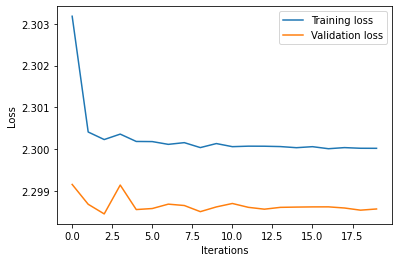

In [96]:
np.save('cache/ train_losses_cnn_2.npy', train_losses_cnn_2)
np.save('cache/ val_losses_cnn_2.npy', val_losses_cnn_2)

train_losses_cnn_2 = np.load('cache/ train_losses_cnn_2.npy', allow_pickle=True)
val_losses_cnn_2 = np.load('cache/ val_losses_cnn_2.npy',allow_pickle=True)

plt.plot(train_losses_cnn_2, label='Training loss')
plt.plot(val_losses_cnn_2, label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
_ = plt.ylim()
# plt.title('Training Validation Loss with CNN from scratch')
# plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
plt.show()

## Transfer Learning - [resnet101] 

In [20]:
# Training function 
def train_model(model, criterion, optimizer, scheduler, num_epochs=10,save_path=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # valid_loss_min = np.Inf 
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                    
                      

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val':
              valid_loss = epoch_loss
            else:
              train_loss = epoch_loss


            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        # print()
      
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    print("saving model ...")
    torch.save(model.state_dict(), save_path)
    return model , train_losses , val_losses

In [21]:

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = valid_loader 

dataset_sizes = {}
dataset_sizes['train'] = np.shape(train_imgs)[0]
dataset_sizes['val'] = np.shape(val_imgs)[0]


### resnet101 [ Stratergy-1 : freezing all layers parameters ] 

In [109]:
pretrained_model_1 = models.resnet101(pretrained=True)

# freezing all parameters 
for param in pretrained_model_1.parameters():
    param.requires_grad = False 

nb_features = pretrained_model_1.fc.in_features 
pretrained_model_1.to(device)

# changing last layer 
pretrained_model_1.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
pretrained_model_1.to(device)
pretrained_model_1.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)

In [110]:
# setting optimizer 
pretrained_criterion_1 = nn.CrossEntropyLoss()
params_1 = list(pretrained_model_1.fc.parameters()) 
pretrained_optimizer_1 = torch.optim.Adam(params_1, lr=0.001)

In [111]:
# scheduler 
# Decay LR by a factor of 0.1 every 7 epochs
from torch.optim import lr_scheduler
exp_lr_scheduler_1 = lr_scheduler.StepLR(pretrained_optimizer_1, step_size=7, gamma=0.1)

In [115]:
# base_model_1 , train_losses_res_1, val_losses_res_1 = train_model(pretrained_model_1, pretrained_criterion_1, pretrained_optimizer_1, exp_lr_scheduler_1, num_epochs=20,
#                            save_path = 'models/resnet_model_1_S1.pt' )


Epoch 0/19
----------
Iterating through data...
train Loss: 2.1458 Acc: 0.1972
Iterating through data...
val Loss: 1.9498 Acc: 0.3289
Epoch 1/19
----------
Iterating through data...
train Loss: 2.0884 Acc: 0.2202
Iterating through data...
val Loss: 1.8843 Acc: 0.3450
Epoch 2/19
----------
Iterating through data...
train Loss: 2.0644 Acc: 0.2261
Iterating through data...
val Loss: 1.9064 Acc: 0.3512
Epoch 3/19
----------
Iterating through data...
train Loss: 2.0539 Acc: 0.2306
Iterating through data...
val Loss: 1.8083 Acc: 0.3874
Epoch 4/19
----------
Iterating through data...
train Loss: 2.0398 Acc: 0.2423
Iterating through data...
val Loss: 1.7825 Acc: 0.4013
Epoch 5/19
----------
Iterating through data...
train Loss: 1.9962 Acc: 0.2601
Iterating through data...
val Loss: 1.7016 Acc: 0.4392
Epoch 6/19
----------
Iterating through data...
train Loss: 1.9863 Acc: 0.2645
Iterating through data...
val Loss: 1.6920 Acc: 0.4526
Epoch 7/19
----------
Iterating through data...
train Loss: 1.

In [22]:
base_model_1 = models.resnet101(pretrained=True)

# freezing all parameters 
for param in base_model_1.parameters():
    param.requires_grad = False 

# nb_features = base_model_1.fc.in_features 
# pretrained_model_1.to(device)

# changing last layer 
base_model_1.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
base_model_1.to(device)
# pretrained_model_1.fc

base_model_1.load_state_dict(torch.load('models/resnet_model_1_S1.pt'))


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


<All keys matched successfully>

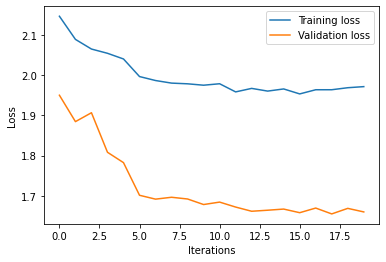

In [137]:

# np.save('cache/ train_losses_res_1.npy', train_losses_res_1)
# np.save('cache/ val_losses_res_1.npy', val_losses_res_1)

train_losses_res_1 = np.load('cache/ train_losses_res_1.npy', allow_pickle=True)
val_losses_res_1 = np.load('cache/ val_losses_res_1.npy',allow_pickle=True)

plt.plot(train_losses_res_1, label='Training loss')
plt.plot(val_losses_res_1, label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
_ = plt.ylim()
# plt.title('Training Validation Loss with CNN from scratch')
# plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
plt.show()


### resnet101 [ Stratergy-2 : frezing previous layers and training only last few ] 

In [140]:
pretrained_model_2 = models.resnet101(pretrained=True)
# pretrained_model_2 = models.vgg16(pretrained=True)

for param in pretrained_model_2.parameters():
    param.requires_grad = False 

for param in pretrained_model_2.layer4.parameters():
    param.requires_grad = True

nb_features = pretrained_model_2.fc.in_features 

pretrained_model_2.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
pretrained_model_2.to(device)
pretrained_model_2.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)

In [141]:
pretrained_criterion_2 = nn.CrossEntropyLoss()
params_2 = list(pretrained_model_2.fc.parameters()) + list(pretrained_model_2.layer4.parameters())
pretrained_optimizer_2 = torch.optim.Adam(params_2, lr=0.001)

In [142]:
from torch.optim import lr_scheduler
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_2 = lr_scheduler.StepLR(pretrained_optimizer_2, step_size=7, gamma=0.1)

In [145]:
# base_model_2,train_losses_res_2,val_losses_res_2 = train_model(pretrained_model_2, pretrained_criterion_2, pretrained_optimizer_2, exp_lr_scheduler_2, num_epochs=9,save_path = 'models/resnet_model_2_S2.pt')

Epoch 0/8
----------
Iterating through data...
train Loss: 0.2982 Acc: 0.8995
Iterating through data...
val Loss: 0.0620 Acc: 0.9838
Epoch 1/8
----------
Iterating through data...
train Loss: 0.2973 Acc: 0.8995
Iterating through data...
val Loss: 0.0533 Acc: 0.9877
Epoch 2/8
----------
Iterating through data...
train Loss: 0.2951 Acc: 0.8988
Iterating through data...
val Loss: 0.0536 Acc: 0.9855
Epoch 3/8
----------
Iterating through data...
train Loss: 0.2931 Acc: 0.9016
Iterating through data...
val Loss: 0.0523 Acc: 0.9861
Epoch 4/8
----------
Iterating through data...
train Loss: 0.2898 Acc: 0.8987
Iterating through data...
val Loss: 0.0514 Acc: 0.9877
Epoch 5/8
----------
Iterating through data...
train Loss: 0.2976 Acc: 0.8979
Iterating through data...
val Loss: 0.0502 Acc: 0.9877
Epoch 6/8
----------
Iterating through data...
train Loss: 0.2864 Acc: 0.8999
Iterating through data...
val Loss: 0.0515 Acc: 0.9877
Epoch 7/8
----------
Iterating through data...
train Loss: 0.2796 Acc

In [24]:
base_model_2 = models.resnet101(pretrained=True)

# freezing all parameters 
for param in base_model_2.parameters():
    param.requires_grad = False 


for param in base_model_2.layer4.parameters():
    param.requires_grad = True

# nb_features = base_model_1.fc.in_features 
# pretrained_model_1.to(device)

# changing last layer 
base_model_2.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
base_model_2.to(device)
# pretrained_model_1.fc

base_model_2.load_state_dict(torch.load('models/resnet_model_2_S2.pt'))


<All keys matched successfully>

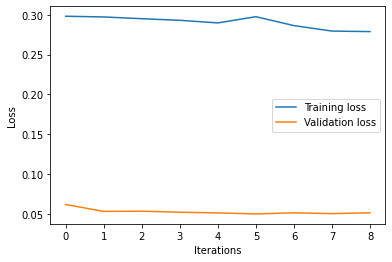

In [146]:

# np.save('cache/ train_losses_res_2.npy', train_losses_res_2)
# np.save('cache/ val_losses_res_2.npy', val_losses_res_2)

train_losses_res_2 = np.load('cache/ train_losses_res_2.npy', allow_pickle=True)
val_losses_res_2 = np.load('cache/ val_losses_res_2.npy',allow_pickle=True)

plt.plot(train_losses_res_2, label='Training loss')
plt.plot(val_losses_res_2, label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
_ = plt.ylim()
# plt.title('Training Validation Loss with CNN from scratch')
# plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
plt.show()


# Visualization on results by resnet - Stratergy 2 

In [162]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

def temp_imshow(inp, title=None):
    # # plt.figure(figsize=(6, 5))
    # inp = inp.numpy().transpose((1, 2, 0))
    # plt.imshow(inp.astype('uint8'))
    # if title is not None:
    #     plt.title(title)
    # plt.pause(0.001)  # Pause a bit so that plots are updated

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated



In [163]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                # print(int(preds[j].item()))
                ax.set_title('predicted: {}'.format(class_names[int(preds[j].item())]))
                temp_imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

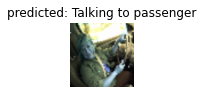

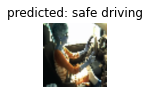

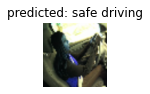

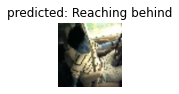

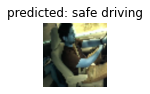

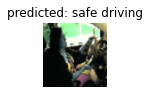

In [164]:
arr = ['safe driving', 'Texting right hand','Talking on the phone using right hand' , 'Texting using left hand' , 'Talking on the phone using left hand' , 'Operating (Adjusting) the radio', 'Drinking' , 'Reaching behind' , 'Hair and makep' , 'Talking to passenger']
class_names = {x : arr[x] for x in [0,1,2,3,4,5,6,7,8,9]}
visualize_model(base_model_2)
plt.show()

# Class Activation Map over resnet 

In [156]:
def display_class_activation_mapping(img , base_model, ax=None):

  class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

  def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

  # CODE TO PREPROCESS IMAGE   
  normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
  )

  # Preprocessing - scale to 224x224 for model, convert to tensor, 
  # and normalize to -1..1 with mean/std for ImageNet

  preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
  ])

  display_transform = transforms.Compose([
    transforms.Resize((224,224))])

  img = Image.fromarray(img).convert('RGB')
  tensor = preprocess(img)
  prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)
  plt.imshow(img)

  # PREDICTION USING MODEL  
  base_model.cuda()
  base_model.eval()


  # save features of final layer 
  final_layer = base_model._modules.get('layer4')

  activated_features = SaveFeatures(final_layer)

  prediction = base_model(prediction_var)

  activated_features.remove()

  weight_softmax_params = list(base_model._modules.get('fc').parameters())
  weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

  # predicted class 
  class_idx = topk(prediction,1)[1].int()
  arr = ['safe driving', 'Texting right hand','Talking on the phone using right hand' , 'Texting using left hand' , 'Talking on the phone using left hand' , 'Operating (Adjusting) the radio', 'Drinking' , 'Reaching behind' , 'Hair and makep' , 'Talking to passenger']
  # print(arr[class_idx])
  
  overlay = getCAM(activated_features.features, weight_softmax, class_idx )

  display_transform = transforms.Compose([
    transforms.Resize((224,224))])

  if ax is None:
    plt.imshow(display_transform(img))
    plt.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');
  else:
    ax.imshow(display_transform(img))
    ax.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

  return arr[class_idx]



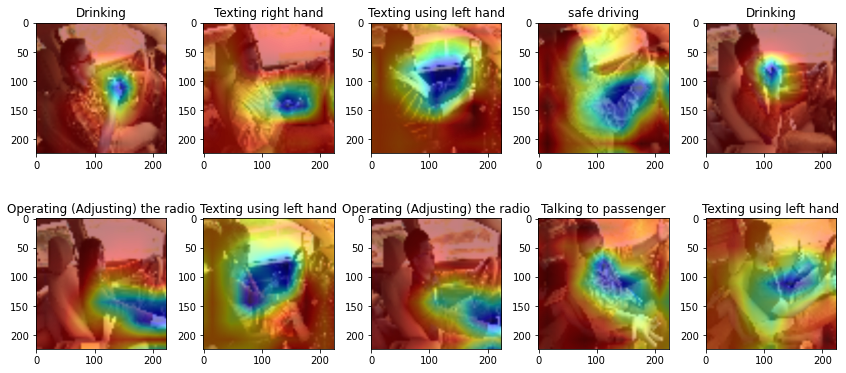

In [157]:
# Displaying some train images 
temp = [20,200,300,400,700,150,900,1000,110,950]
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
j = 0
for i, ax in enumerate(axs.ravel()):
  t = display_class_activation_mapping(val_imgs[temp[j]] , base_model_2,ax)
  ax.title.set_text(t)
  j = j+1 


# Testing 

In [28]:
def test(test_loaders, model, criterion):
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loaders):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
            
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    return y, y_hat

In [29]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## CNN testing 

In [45]:
# Testing test data set over CNN and images 64*64 
y, y_hat = test(test_loader2, CNN_model_1_64, criterion)

Test Loss: 0.083884


Test Accuracy: 97% (4389/4485)


In [46]:
cm1 = confusion_matrix(y, y_hat)

In [47]:
target_names = ['0', '1', '2','3', '4','5','6','7','8','9']
print(classification_report(y, y_hat, target_names=target_names))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       498
           1       0.98      0.99      0.99       453
           2       0.99      0.99      0.99       464
           3       0.98      0.99      0.99       469
           4       1.00      0.98      0.99       465
           5       1.00      0.98      0.99       463
           6       0.99      0.97      0.98       465
           7       0.97      0.98      0.97       400
           8       0.95      0.95      0.95       382
           9       0.97      0.96      0.96       426

    accuracy                           0.98      4485
   macro avg       0.98      0.98      0.98      4485
weighted avg       0.98      0.98      0.98      4485



<Figure size 432x288 with 0 Axes>

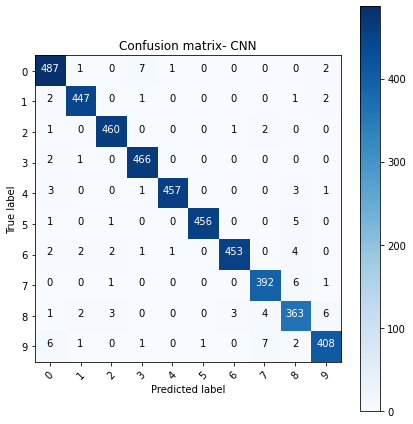

In [48]:
plt.figure()
confusion_matrix2(cm1, classes=['0','1','2','3','4','5','6','7','8','9'],title='Confusion matrix- CNN',
                           filename='Confusion Matrix with CNN from scratch', figsize=(6,6))

## Resnet testing 

## S1 

In [49]:
# Testing test data set over Resnet and images 224*224 stratery1
y, y_hat = test(test_loader,base_model_1 , criterion)

Test Loss: 1.658574


Test Accuracy: 47% (2117/4485)


In [50]:
cm2 = confusion_matrix(y, y_hat)

In [51]:
target_names = ['0', '1', '2','3', '4','5','6','7','8','9']
print(classification_report(y, y_hat, target_names=target_names))

              precision    recall  f1-score   support

           0       0.37      0.70      0.49       498
           1       0.42      0.28      0.33       453
           2       0.46      0.63      0.53       464
           3       0.51      0.61      0.55       469
           4       0.54      0.55      0.54       465
           5       0.59      0.57      0.58       463
           6       0.45      0.51      0.48       465
           7       0.51      0.72      0.60       400
           8       0.60      0.01      0.02       382
           9       0.50      0.04      0.07       426

    accuracy                           0.47      4485
   macro avg       0.50      0.46      0.42      4485
weighted avg       0.49      0.47      0.43      4485



<Figure size 432x288 with 0 Axes>

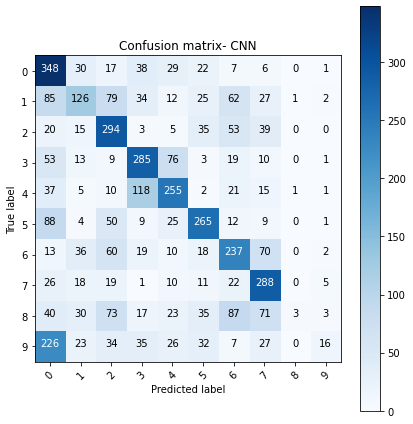

In [52]:
plt.figure()
confusion_matrix2(cm2, classes=['0','1','2','3','4','5','6','7','8','9'],title='Confusion matrix- CNN',
                           filename='Confusion Matrix with CNN from scratch', figsize=(6,6))

## S2

In [53]:
# Testing test data set over Resnet and images 224*224 stratery2 
y, y_hat = test(test_loader,base_model_2 , criterion)

Test Loss: 0.045815


Test Accuracy: 98% (4423/4485)


In [54]:
cm3 = confusion_matrix(y, y_hat)

In [55]:
target_names = ['0', '1', '2','3', '4','5','6','7','8','9']
print(classification_report(y, y_hat, target_names=target_names))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       498
           1       0.99      0.99      0.99       453
           2       0.99      1.00      0.99       464
           3       1.00      1.00      1.00       469
           4       0.99      1.00      1.00       465
           5       1.00      0.99      1.00       463
           6       0.99      0.97      0.98       465
           7       1.00      1.00      1.00       400
           8       0.97      0.95      0.96       382
           9       0.98      0.97      0.97       426

    accuracy                           0.99      4485
   macro avg       0.99      0.99      0.99      4485
weighted avg       0.99      0.99      0.99      4485



<Figure size 432x288 with 0 Axes>

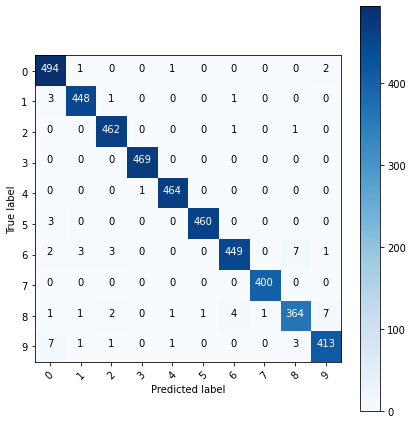

In [56]:
plt.figure()
confusion_matrix2(cm3, classes=['0','1','2','3','4','5','6','7','8','9'],title='',
                           filename='Confusion Matrix with CNN from scratch', figsize=(6,6))